In [2]:
import time
from pathlib import Path
from pprint import pprint
from statistics import mean, stdev

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.io import wavfile
from scipy.signal import freqz
from torch import Tensor
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange

from src.dataset import SignalTrainDataset, download_signal_train_dataset_to
from src.loss import forge_validation_criterions_by
from src.model import S4ConditionalModel
from src.model.layer import DSSM, convert_to_decibel
from src.parameter import ConditionalTaskParameter
from src.utils import get_tensor_device, set_random_seed_to

# S4 Hyper-conditioning Dynamic Range Compressor Model Evaluation

This Jupyter Notebook contains routine to evaluate a trained single-chain S4 DRC model with hyper-conditioning.

Edit and execute the code in the [Preparatory Work](#preparatory-work) section first to load the model,
and then execude the code in the rest of the section to evaluate each individual metrics.

Each individual evaluation task is wrapped in a function to prevent variables going global,
All functions will save results to the local file system.

## <a id="preparatory-work">Preparatory Work</a>

Edit the following global constant to locate the model to be evaluated.

If the model is trained properly using my given script, you don't need to edit any other cell.

In [3]:
DATASET_DIR = Path('./data/SignalTrain')

CHECKPOINT_DIR = Path('./experiment-result')
JOB_NAME = '2023-5-10-15-27-38'
EPOCH = 66

TESTING_DATASET_SEGMENT_LENGTH = 10.0
TESTING_DATASET_BATCH_SIZE = 5
TESTING_DATASET_SAMPLE_INDEX = [10, 20, 100, 200, 234]

Execute the following code to load the model and configuration.

In [4]:
job_dir = CHECKPOINT_DIR / JOB_NAME
job_eval_dir = job_dir / 'evaluations'
device = get_tensor_device(apple_silicon=False)  # Some operations are not supported on Apple Silicon
param = ConditionalTaskParameter.from_json(CHECKPOINT_DIR / JOB_NAME / 'config.json')
pprint(param.to_dict())

set_random_seed_to(param.random_seed)

download_signal_train_dataset_to(DATASET_DIR)
testing_dataset_short = SignalTrainDataset(DATASET_DIR, 'test', 1.5)
testing_dataset_mid = SignalTrainDataset(DATASET_DIR, 'test', 4)
testing_dataset_long = SignalTrainDataset(DATASET_DIR, 'test', 10)
testing_datasets = {
    'short': testing_dataset_short,
    'mid': testing_dataset_mid,
    'long': testing_dataset_long,
}

model = S4ConditionalModel(
    param.model_take_side_chain,
    param.model_inner_audio_channel,
    param.model_s4_hidden_size,
    param.s4_learning_rate,
    param.model_depth,
    param.model_film_take_batchnorm,
    param.model_take_residual_connection,
    param.model_convert_to_decibels,
    param.model_take_tanh,
    param.model_activation,
).eval().to(device)
model.load_state_dict(torch.load(CHECKPOINT_DIR / JOB_NAME / f'model-epoch-{EPOCH}.pth', map_location=device))

{'batch_size': 64,
 'checkpoint_dir': PosixPath('experiment-result'),
 'data_segment_length': 1.0,
 'dataset_dir': PosixPath('data/SignalTrain'),
 'enable_learning_rate_scheduler': True,
 'epoch': 70,
 'learning_rate': 0.001,
 'log_wandb': True,
 'loss': 'ESR+DC+Multi-STFT',
 'loss_filter_coef': 0.85,
 'model_activation': 'PReLU',
 'model_convert_to_decibels': False,
 'model_depth': 4,
 'model_film_take_batchnorm': True,
 'model_inner_audio_channel': 32,
 'model_s4_hidden_size': 4,
 'model_take_residual_connection': True,
 'model_take_side_chain': False,
 'model_take_tanh': True,
 'random_seed': 42,
 's4_learning_rate': 0.001,
 'save_checkpoint': True,
 'wandb_entity': 'int0thewind',
 'wandb_project_name': 'S4 Dynamic Range Compressor'}
The SignalTrain dataset has been downloaded. Skipping ... 


Loading test dataset.:   0%|          | 0/6 [00:00<?, ?it/s]

<All keys matched successfully>

## LA-2A Envelope Analysis

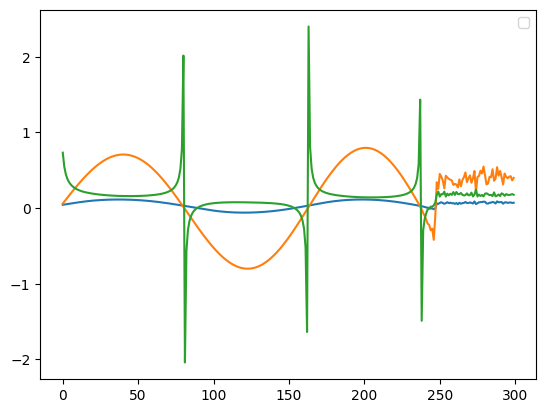

In [5]:
@torch.no_grad()
def envelope_analysis():
    x, y, cond = testing_dataset[TESTING_DATASET_SAMPLE_INDEX[-1]]
    s = slice(0, 300)
    x = x[s].detach().cpu().numpy()
    y = y[s].detach().cpu().numpy()
    c = y / x
    fig, ax = plt.subplots()
    ax.plot(y)
    ax.plot(x)
    ax.plot(c)
    handles, lables = ax.get_legend_handles_labels()
    ax.legend(handles, lables)
    fig.show()

envelope_analysis()

## General Testing

In [ ]:
@torch.no_grad()
def test():
    for dataset_name, dataset in testing_datasets.items():
        dataloader = DataLoader(dataset, 64, num_workers=8, pin_memory=True)

        validation_criterions = forge_validation_criterions_by(param.loss_filter_coef, device)
        validation_losses = {
            validation_loss: 0.0
            for validation_loss in validation_criterions.keys()
        }

        for x, y, parameters in tqdm(
            dataloader, desc=f'Testing {dataset_name} datset.', total=len(dataloader)
        ):
            x: Tensor = x.to(device)
            y: Tensor = y.to(device)
            parameters: Tensor = parameters.to(device)

            y_hat: Tensor = model(x, parameters)

            for validation_loss, validation_criterion in validation_criterions.items():
                loss: Tensor = validation_criterion(y_hat.unsqueeze(1), y.unsqueeze(1))
                validation_losses[validation_loss] += loss.item()
        
        for k, v in list(validation_losses.items()):
            validation_losses[k] = v / len(dataloader)
        
        with open(job_eval_dir / f'loss-{dataset_name}.txt', 'w') as f:
            pprint(validation_losses, stream=f)
            print('\n', file=f)

test()

## S4 Frequency Response Analysis

In [ ]:
@torch.no_grad()
def s4_frequency_response_analysis():
    for c, block in enumerate(model.blocks):
        s4 = block.s4
        assert isinstance(s4, DSSM)
        kernel = s4.get_kernel(int(SignalTrainDataset.sample_rate * 1))
        for r in trange(param.model_inner_audio_channel, desc=f'Block {c}.'):
            impulse_response = kernel[r, :].detach().cpu().numpy()
            w, h = freqz(impulse_response)
            title = f'layer-{c + 1}-channel-{r + 1}'

            fig, ax = plt.subplots()
            ax.set_title(title)
            ax.plot(w, 20 * np.log10(abs(h)), 'b')
            ax.set_xlabel('Frequency [rad/sample]')
            ax.set_ylabel('Amplitude [dB]', color='b')
            ax2 = ax.twinx()
            ax2.plot(w, np.unwrap(np.angle(h)), 'g')
            ax2.set_ylabel('Angle (radians)', color='g')
            ax2.grid(True)
        
            fig.savefig(str(job_eval_dir / 's4-impulse-response' / f'{title}.png'))
            plt.close(fig)

s4_frequency_response_analysis()

## Evaluate Inference Efficiency

In [8]:
@torch.no_grad()
def evaluate_inference_efficiency():
    if device.type == 'cpu':
        print(f'Doing inference speed test on CPU...')
    elif device.type == 'cuda':
        print(f'Doing inference speed test on {torch.cuda.get_device_name()}.')
    
    print(f'Individual sample length: {TESTING_DATASET_SEGMENT_LENGTH} seconds.')

    inference_time: list[int] = []

    for i in tqdm(range(10)):
        x, _, cond = testing_dataset.collate_fn([testing_dataset[i]])
        x = x.to(device)
        cond = cond.to(device)

        tic = time.perf_counter_ns()
        model(x, cond)
        toc = time.perf_counter_ns()
        inference_time.append(toc - tic)
    
    inference_time_mean = mean(inference_time) / 1e6
    print(f'Average inference time: {inference_time_mean} ms.')
    inference_time_stdev = stdev(inference_time) / 1e6
    print(f'Inference time standard deviation: {inference_time_stdev} ms.')
    speed_ratio = inference_time_mean / (TESTING_DATASET_SEGMENT_LENGTH * 1e3)
    print(f'Real-time speed ratio: {speed_ratio}.')

evaluate_inference_efficiency()

Doing inference speed test on NVIDIA GeForce RTX 3090.
Individual sample length: 10.0 seconds.


  0%|          | 0/10 [00:00<?, ?it/s]

Average inference time: 52.0624977 ms.
Inference time standard deviation: 0.46266824237581106 ms.
Real-time speed ratio: 0.00520624977.


## Evaluate Output Audio

In [ ]:
@torch.no_grad()
def evaluate_output_audio():
    # Audio output, waveform difference, RMS difference and STFT difference
    for dataset_name, dataset in testing_datasets.items():
        dataloader = DataLoader(dataset, 64, num_workers=8, pin_memory=True)

        output_dir = job_eval_dir / f'output-audio-{dataset_name}'
        output_dir.mkdir()

        ii = 0
        for x, y, cond in tqdm(dataloader, desc=f'Evaluate {dataset_name} dataset.', total=len(dataloader)):
            x: Tensor = x.to(device)
            y: Tensor = y.to(device)
            cond: Tensor = cond.to(device)
            
            y_hat: Tensor = model(y, cond)
            
            for i in range(y_hat.size(0)):
                switch, peak_reduction = cond[i, :].flatten().cpu().tolist()
                x_audio = x[i, :].flatten()
                y_audio = y[i, :].flatten()
                y_hat_audio = y_hat[i, :].flatten()
                y_diff_audio = y_audio - y_hat_audio

                y_stft = torch.stft(y_audio, n_fft=1024, hop_length=256, win_length=1024, return_complex=True)
                y_hat_stft = torch.stft(y_hat_audio, n_fft=1024, hop_length=256, win_length=1024, return_complex=True)
                y_diff_stft = (y_stft.abs() - y_hat_stft.abs()).log10().mul(10).cpu().numpy()

                x_audio = x_audio.cpu().numpy()
                y_audio = y_audio.cpu().numpy()
                y_hat_audio = y_hat_audio.cpu().numpy()
                y_diff_audio = y_diff_audio.cpu().numpy()

                prefix = f'{str(ii).zfill(3)}-switch={switch}-peak-reduction={peak_reduction}'
                wavfile.write(f'{prefix}-x.wav', SignalTrainDataset.sample_rate, x_audio)
                wavfile.write(f'{prefix}-y.wav', SignalTrainDataset.sample_rate, y_audio)
                wavfile.write(f'{prefix}-y-hat.wav', SignalTrainDataset.sample_rate, y_hat_audio)
                wavfile.write(f'{prefix}-y-diff.wav', SignalTrainDataset.sample_rate, y_diff_audio)

                fig, ax = plt.subplots(figsize=(25, 5))
                ax.plot(y_diff_audio)
                ax.set_title(f'{prefix}')
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Amplitude')
                fig.savefig(f'{prefix}-y-diff.png')
                plt.close(fig)

                fig, ax = plt.subplots(figsize=(25, 5))
                ax.pcolormesh(y_diff_stft, cmap='jet')
                ax.set_title(f'{prefix}')
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Magnitude')
                fig.savefig(f'{prefix}-y-stft-diff.png')
                plt.close(fig)

                ii += 1

evaluate_output_audio()

## Evaluate RMS Difference

In [11]:
@torch.no_grad()
def evaluate_rms_difference():
    raise NotImplementedError('This is not implemented yet.')
    x, y, cond = testing_dataset.collate_fn([testing_dataset[i] for i in TESTING_DATASET_SAMPLE_INDEX])
    x = x.to(device)
    y = y.to(device)
    cond = cond.to(device)
    
    y_hat: Tensor = model(y, cond)
    
    fig, axes = plt.subplots(5, 1, figsize=(25, 25))
    for i, (y_audio, y_hat_audio, cond_data) in enumerate(zip(
        y.split(1), y_hat.split(1), cond.split(1),
    )):
        diff = (y_audio - y_hat_audio).flatten().cpu()
        switch, peak_reduction = cond_data.flatten().cpu().tolist()
        ax = axes[i]
        ax.plot(diff.numpy())
        ax.set_title(
            f'Waveform Difference (Switch: {switch}, '
            f'Peak reduction: {peak_reduction}) '
            f'Mean {diff.abs().mean().item():.8f}'
        )
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')
    
    fig.show()

evaluate_rms_difference()

NotImplementedError: This is not implemented yet.

## Evaluate Model Step Response

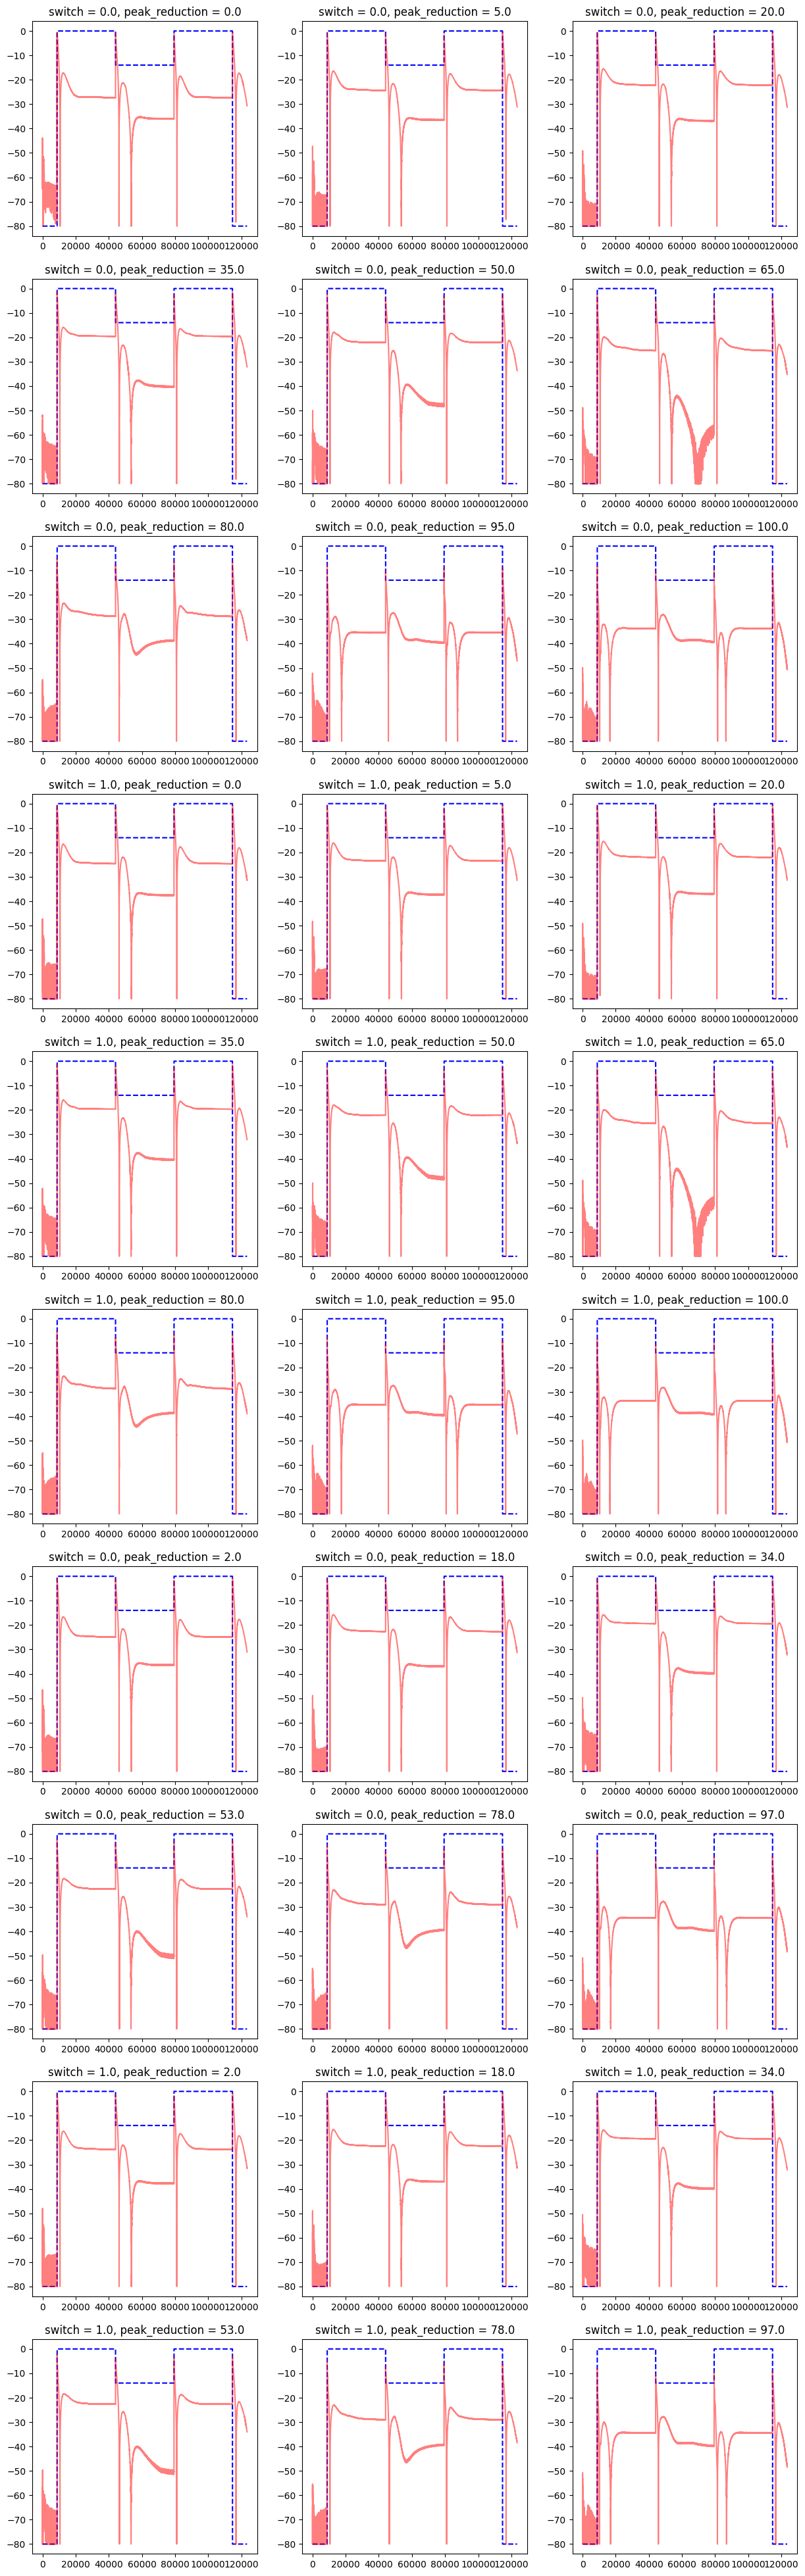

In [13]:
@torch.no_grad()
def evaluate_model_step_response():
    parameter_pair = torch.tensor([
        [0, 0],
        [0, 5],
        [0, 20],
        [0, 35],
        [0, 50],
        [0, 65],
        [0, 80],
        [0, 95],
        [0, 100],
        [1, 0],
        [1, 5],
        [1, 20],
        [1, 35],
        [1, 50],
        [1, 65],
        [1, 80],
        [1, 95],
        [1, 100],
        [0, 2],
        [0, 18],
        [0, 34],
        [0, 53],
        [0, 78],
        [0, 97],
        [1, 2],
        [1, 18],
        [1, 34],
        [1, 53],
        [1, 78],
        [1, 97],
    ]).to(device, torch.float32)
    
    sr = SignalTrainDataset.sample_rate
    step_signal = torch.cat([
        torch.zeros(int(sr * 0.2)),
        torch.ones(int(sr * 0.8)),
        torch.zeros(int(sr * 0.8)) + 0.2,
        torch.ones(int(sr * 0.8)),
        torch.zeros(int(sr * 0.2)),
    ]).to(device, torch.float32)
    output_signals: Tensor = model(
        step_signal.repeat(parameter_pair.size(0), 1),
        parameter_pair,
    )
    step_signal_decibel = convert_to_decibel(step_signal)
    
    fig, axs = plt.subplots(10, 3, figsize=(15, 50))
    for i, output_signal in enumerate(output_signals.split(1)):
        switch, peak_reduction = parameter_pair[i].tolist()
        row, col = divmod(i, 3)
        ax = axs[row][col]
        ax.plot(step_signal_decibel.cpu().numpy(), color='blue', linestyle='dashed', alpha=1.0)
        ax.plot(convert_to_decibel(output_signal).flatten().cpu().numpy(), color='red', linestyle='solid', alpha=0.5)
        ax.set_title(f'{switch = }, {peak_reduction = }')
    fig.savefig(str(job_eval_dir / f'model-step-response.png'))
    
evaluate_model_step_response()